<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/Calculation_ATE_ATT_From_PBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# GoogleCoraboratoryで実験する場合にMyDriveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 対象ディレクトリに移動
cd /content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/PBC

/content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/PBC


In [3]:
ls

Calculation_ATE_ATT_From_PBC.ipynb  datasets/  exports/  memo.txt


In [0]:
import pandas as pd
import numpy as np

#原発性胆汁性胆管炎（Primary biliary cholangitis：PBC）に対してD-ペニシラミンを用いたA/Bテストの結果からD-ペニシラミンの（因果）効果検証を行う

## 参考書籍
- [効果検証入門〜正しい比較のための因果推論/計量経済学の基礎](https://www.amazon.co.jp/%E5%8A%B9%E6%9E%9C%E6%A4%9C%E8%A8%BC%E5%85%A5%E9%96%80%E3%80%9C%E6%AD%A3%E3%81%97%E3%81%84%E6%AF%94%E8%BC%83%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E5%9B%A0%E6%9E%9C%E6%8E%A8%E8%AB%96-%E8%A8%88%E9%87%8F%E7%B5%8C%E6%B8%88%E5%AD%A6%E3%81%AE%E5%9F%BA%E7%A4%8E-%E5%AE%89%E4%BA%95-%E7%BF%94%E5%A4%AA/dp/4297111179/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&keywords=%E5%8A%B9%E6%9E%9C%E6%A4%9C%E8%A8%BC&qid=1582603763&sr=8-1)
- [超絶解説 医学論文の難解な統計手法が手に取るようにわかる本](https://www.amazon.co.jp/%E8%B6%85%E7%B5%B6%E8%A7%A3%E8%AA%AC-%E5%8C%BB%E5%AD%A6%E8%AB%96%E6%96%87%E3%81%AE%E9%9B%A3%E8%A7%A3%E3%81%AA%E7%B5%B1%E8%A8%88%E6%89%8B%E6%B3%95%E3%81%8C%E6%89%8B%E3%81%AB%E5%8F%96%E3%82%8B%E3%82%88%E3%81%86%E3%81%AB%E3%82%8F%E3%81%8B%E3%82%8B%E6%9C%AC-%E5%BA%B7%E6%B0%B8-%E7%A7%80%E7%94%9F/dp/4307004876/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&keywords=%E9%9B%A3%E8%A7%A3+%E5%8C%BB%E7%99%82&qid=1582603837&sr=8-1)

## ざっくりRubinの因果推論手法とは
-   介入を受けた際の結果を$Y^{(1)}$、介入を受けなかった際の結果を$Y^{(0)}$と定義した時、**結果の差（$Y^{(1)}-Y^{(0)}$）から、介入の因果効果 ${\tau}$ を求めることができる。**

- **RCT（ランダム化比較実験）が成り立っている場合**のサンプルデータに対しては、**各グループの平均値の差（$E[Y^{(1)}]-E[Y^{(0)}]$）から、因果効果 $τ$ を求めることができる。**

- **RCTで介入の割り当てを無作為化作為化することがで、介入以外の他の因子の効果（共変量や交絡因子）を２つのグループ間で揃えられる。**

- しかし、RCT実施には膨大なコストがかかるため、なかなか実施できない。そのため、**因果推論分野では、RCTが成り立っていない実験データから、共変量、交絡因子の影響を取り除き、RCTに近い状況を作り出し、介入の効果を求める手法が提案されている。**


手順

1.   データの前処理
2.   （あまり良くない方法で）A/Bテストを評価
</br>**（↓ここから因果推論手法を使ってみる）**
3.    （準備）傾向スコアの導出
4.   「IPW」で**因果効果ATE**を求めA/Bテストを評価
5.   「傾向スコアマッチング」で**因果効果ATT**を求めA/Bテストを評価<br>

**Primary Biliary Cirrhosis (PBC) Data**
*   PBC患者を対象にA/Bテストを実施したデータ
*  原発性胆汁性胆管炎（指定難病９３）について：[https://www.nanbyou.or.jp/entry/252](https://www.nanbyou.or.jp/entry/252)

<br>

**重要なカラム**
*   介入変数（treatment）：drug（D-ペニシラミン）
*   アウトカム（outcome）：status（生存したか死亡したか）


<br>

**実験データのカラム説明：
[https://www4.stat.ncsu.edu/~boos/var.select/pbc.html](https://www4.stat.ncsu.edu/~boos/var.select/pbc.html)**
* id       = case number
* futime   = number of days between registration and the earlier of death,transplantion, or study analysis time in July, 1986
* status   = **（アウトカム）**0=alive, 1=liver transplant, 2=dead
* drug     = **（介入変数）** 1= D-penicillamine, 2=placebo
* age      = age in days
* sex      = 0=male, 1=female
* ascites  = presence of ascites: 0=no 1=yes
* hepato   = presence of hepatomegaly 0=no 1=yes
* spiders  = presence of spiders 0=no 1=yes
* edema    = presence of edema 0=no edema and no diuretic therapy for edema; .5 = edema present without diuretics, or edema resolved by diuretics; 1 = edema despite diuretic therapy
* bili     = serum bilirubin in mg/dl
* chol     = serum cholesterol in mg/dl
* albumin  = albumin in gm/dl
* copper   = urine copper in ug/day
* alk_phos = alkaline phosphatase in U/liter
* sgot     = SGOT in U/ml
* trig     = triglicerides in mg/dl
* platelet = platelets per cubic ml/1000
* protime  = prothrombin time in seconds
* stage    = histologic stage of disease




In [5]:
DATASET_PATH = './datasets/analytical_data.csv'
EXPERIMENT_DATA_DF = pd.read_csv(DATASET_PATH)
TREATMENT_COLUMN = 'drug'
OUTCOME_COLUMN = 'status'
print("ExperimentDataSize:{data}".format(data=EXPERIMENT_DATA_DF.shape))

ExperimentDataSize:(418, 20)


In [6]:
EXPERIMENT_DATA_DF

,id,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
0,1,400,2,1,21464,1,1,1,1,1.0,14.5,261,2.60,156,1718,137.95,172,190,12.2,4
1,2,4500,0,1,20617,1,0,1,1,0.0,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
2,3,1012,2,1,25594,0,0,0,0,0.5,1.4,176,3.48,210,516,96.1,55,151,12,4
3,4,1925,2,1,19994,1,0,1,1,0.5,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
4,5,1504,1,2,13918,1,0,1,1,0.0,3.4,279,3.53,143,671,113.15,72,136,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,2,.,24472,1,.,.,.,0.0,1.2,.,2.96,.,.,.,.,174,10.9,3
414,415,1103,0,.,14245,1,.,.,.,0.0,0.9,.,3.83,.,.,.,.,180,11.2,4
415,416,1055,0,.,20819,1,.,.,.,0.0,1.6,.,3.42,.,.,.,.,143,9.9,3
416,417,691,0,.,21185,1,.,.,.,0.0,0.8,.,3.75,.,.,.,.,269,10.4,3


#①DataPreprocessing

今回はATE求める練習のため前処理は簡単に以下処理のみ行う
*   D-penicillamineが投与された場合は1、placeboの場合は0に値変更
*   欠測値を含むユーザを除く
*   肝移植したユーザ（status=1）をのぞく
*   生存=0,死亡=2　⇒　生存=1,死亡=0に置き換え




In [0]:
def rewrite_categorical_binary_variable_value(data, stored_column, flag_var, non_flag_var):
    """二値カテゴリ変数の書き換え

      WARNING:二値変数以外の値を取るカラムを渡して実行してはいけない

      Args:
         flag_val{category_name, current_val}(dict): 値を1にしたいカテゴリ {カテゴリ名, 現在格納されている値}
         non_flag_val{category_name, current_val}(dict): 値を0にしたいカテゴリ {カテゴリ名, 現在格納されている値}
    """
    data[stored_column] = data[stored_column].replace(flag_var['current_val'], flag_var['category_name']).replace(non_flag_var['current_val'], non_flag_var['category_name'])
    data[stored_column] = data[stored_column].replace(flag_var['category_name'], 1).replace(non_flag_var['category_name'], 0)
    return data

def remove_missing_value_line(data):
    """欠測値のある行を取り除く

     「.」のみまたは空白のデータが含まれる行を取り除く

    """
    for colum in data.columns.tolist():
        data.query("not " + colum + " in ['.', '']", inplace=True)
    preproccesing_data = data
    return preproccesing_data


def remove_status1_person(data):
    """肝移植したユーザを除く

     statusカラムが1となっている行を除く

    """
    preproccesing_data = data.query('not status == 1')
    return preproccesing_data

In [0]:
def remove_any_columns_data(data, remove_columnlist=None):
    return data if remove_columnlist == None else data.drop(remove_columnlist, axis = 1)

def remove_element_from_list(target_list, expect_list):
    return list(set(target_list) ^ set(expect_list))

def df_change_type_to_double(data, expect_columnlist=None):
    if expect_columnlist == None:
       data = data.astype('float64')
    else:
       process_columns = remove_element_from_list(data.columns.tolist(), expect_columnlist)
       data[process_columns] = data[process_columns].astype('float64')
    return data

def preproccesing_data(origin_data):
    """データ前処理用

    Args:
        origin_data(df): 整形前のデータ

    Returns:
        preprocessed_data(df): 整形後のデータ
    """
    stored_column, flag_var, non_flag_var = TREATMENT_COLUMN, {'category_name' : 'D-penicillamine', 'current_val' : '1'}, {'category_name' : 'placebo', 'current_val' : '2'}
    preproccessed_data = rewrite_categorical_binary_variable_value(origin_data, stored_column, flag_var, non_flag_var)
    
    preproccessed_data = remove_missing_value_line(preproccessed_data)
    
    preproccessed_data = remove_status1_person(preproccessed_data)

    stored_column_st, flag_var_st, non_flag_var_st = 'status', {'category_name' : 'dead', 'current_val' : 2}, {'category_name' : 'survive', 'current_val' : 0}
    preproccessed_data = rewrite_categorical_binary_variable_value(preproccessed_data.copy(), stored_column_st, flag_var_st, non_flag_var_st)

    preproccessed_data = remove_any_columns_data(preproccessed_data, ['id'])

    preproccessed_data = df_change_type_to_double(preproccessed_data, ['drug', 'status'])

    return preproccessed_data

In [9]:
PREPROCESSED_DATA = preproccesing_data(EXPERIMENT_DATA_DF)
print("PreprocessedDataSize:{data}".format(data=PREPROCESSED_DATA.shape))

PreprocessedDataSize:(258, 19)


In [10]:
PREPROCESSED_DATA

,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
0,400.0,1,1,21464.0,1.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500.0,0,1,20617.0,1.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012.0,1,1,25594.0,0.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925.0,1,1,19994.0,1.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,1832.0,0,0,20284.0,1.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153.0,0,1,22347.0,1.0,0.0,1.0,0.0,0.0,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0
308,994.0,0,0,21294.0,1.0,0.0,0.0,0.0,0.0,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0
309,939.0,0,1,22767.0,1.0,0.0,0.0,0.0,0.0,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0
310,839.0,0,1,13879.0,1.0,0.0,0.0,0.0,0.0,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0


In [0]:
def extract_any_category_data(data, target_categorical_name, target_categorical_num):
    extracted_data = data[data[target_categorical_name] == target_categorical_num]
    return extracted_data

In [0]:
TREATMENTGROUP_DATA = extract_any_category_data(PREPROCESSED_DATA, TREATMENT_COLUMN, 1)
CONTROLGROUP_DATA = extract_any_category_data(PREPROCESSED_DATA, TREATMENT_COLUMN, 0)
#print(TREATMENTGROUP_DATA)
#print(CONTROLGROUP_DATA)

In [13]:
print("TreatmentGroupSize:{treated_size}".format(treated_size = TREATMENTGROUP_DATA.shape[0]))
print("ControlGroupSize:{control_size}".format(control_size=CONTROLGROUP_DATA.shape[0]))

TreatmentGroupSize:127
ControlGroupSize:131


In [14]:
# 介入群の統計量
TREATMENTGROUP_DATA.describe().loc[['mean', 'min','25%', '50%','75%','max']]

,futime,status,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
mean,2001.03937,0.448819,18979.551181,0.866142,0.086614,0.472441,0.307087,0.129921,2.925984,353.543307,3.487953,101.606299,2030.993701,120.61622,124.401575,255.110236,10.677953,2.952756
min,41.00000,0.000000,9598.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,127.000000,2.100000,9.000000,369.000000,45.00000,46.000000,62.000000,9.000000,1.000000
25%,1234.50000,0.000000,16270.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,246.500000,3.200000,42.500000,856.000000,81.30000,85.000000,191.000000,10.000000,2.000000
50%,1827.00000,0.000000,19155.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.400000,309.000000,3.540000,74.000000,1214.000000,113.15000,106.000000,251.000000,10.600000,3.000000
75%,2673.00000,1.000000,21969.500000,1.000000,0.000000,1.000000,1.000000,0.000000,3.300000,415.000000,3.780000,123.500000,2093.000000,150.95000,146.000000,317.500000,11.000000,4.000000
max,4556.00000,1.000000,28650.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,1600.000000,4.400000,588.000000,11552.000000,338.00000,598.000000,563.000000,14.100000,4.000000


In [15]:
# コントロール群の統計量
CONTROLGROUP_DATA.describe().loc[['mean', 'min','25%', '50%','75%','max']]

,futime,status,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
mean,2022.206107,0.412214,17875.015267,0.89313,0.061069,0.534351,0.274809,0.091603,3.745038,379.061069,3.534198,96.854962,2030.187786,126.675191,124.305344,263.694656,10.835878,3.099237
min,51.000000,0.000000,11167.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,44.000000,71.000000,9.500000,1.000000
25%,1188.500000,0.000000,15505.500000,1.00000,0.000000,0.000000,0.000000,0.000000,0.700000,252.000000,3.350000,41.000000,959.500000,82.355000,85.000000,205.500000,10.000000,3.000000
50%,1832.000000,0.000000,17809.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.300000,302.000000,3.540000,73.000000,1307.000000,119.350000,113.000000,258.000000,10.600000,3.000000
75%,2796.500000,1.000000,20417.000000,1.00000,0.000000,1.000000,1.000000,0.000000,3.600000,388.000000,3.765000,135.000000,2090.000000,157.325000,156.500000,322.000000,11.450000,4.000000
max,4523.000000,1.000000,27220.000000,1.00000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.380000,558.000000,13862.400000,457.250000,432.000000,487.000000,17.100000,4.000000


#②（あまり良くない方法で）A/Bテストを評価

In [0]:
def calc_naive_tau(outcome_column_name, tratment_group_data, control_group_data):
    """　単純なoutcomeの差を求める

     WARNING:誤った効果測定の方法
　　 計算方法：介入群のoutcomeの平均値 - 対照群のoutcomeの平均値
    """
    naive_tau = tratment_group_data[outcome_column_name].mean() - control_group_data[outcome_column_name].mean()
    return naive_tau

In [17]:
naive_tau_hat = calc_naive_tau(OUTCOME_COLUMN, TREATMENTGROUP_DATA, CONTROLGROUP_DATA)
print("naiveτ~（純粋な差） = {naive_tau_hat}".format(naive_tau_hat = naive_tau_hat))

naiveτ~（純粋な差） = 0.03660515717977997


## 「２つのグループの平均値をそれぞれ求め、単純に引き算する方法」があまり良くない理由について
-  **セレクションバイアスが生じている**
    - 結果が観測されたデータのみで効果測定している
    - 共変量、交絡因子が揃っていない（被験者のユーザ毎の特徴量の差が結果に影響している可能性）

A/Bテストで収集されたデータをサンプルデータ（標本）と考えた際、母集団内での因果効果を ${\tau}$ と置くと、標本から推定される因果効果の推定量は $\hat{\tau}$ と定義することができる。<br>

今回求めた純粋な差から求めた推定量を$\hat{\tau}_{naive}$と置くと、
$$\hat{\tau}_{naive} = E[Y^{(1)}|Z=1]-E[Y^{(0)}|Z=0]$$
$$=E[Y^{(1)}-Y^{(0)}]+E[Y^{(0)}|Z=1]-E[Y^{(0)}|Z=0]$$
介入の因果効果（第1項目）以外に、セレクションバイアス（第2項目と第3項目）が含まれてしまっていることが分かる。

# ③（因果推論手法を用いた）因果効果測定

## （準備）傾向スコアの算出
今回はLogistic Regression（ロジスティック回帰）を使い、傾向スコア（被験者の共変量に応じて介入群に割り振られる確率）を算出

In [0]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

ss = preprocessing.StandardScaler()
lr = LogisticRegression(random_state = 8, C=0.1)

In [0]:
def process_standardization(data):
    return ss.fit_transform(data)

def preprocess_data_for_regression(data, extract_column_list = None):
    """回帰用データ整形
    
    ①不要なカラムの削除
    ②データの標準化

    """
    processed_data = remove_any_columns_data(data, extract_column_list)

    processed_data_np = process_standardization(processed_data)
    
    return processed_data_np

In [0]:
# トリートメント割り当て確率を予測するための特徴量
TRAINING_VECTOR_X= preprocess_data_for_regression(PREPROCESSED_DATA, [TREATMENT_COLUMN, OUTCOME_COLUMN])
#pd.DataFrame(TRAINING_VECTOR_X).describe()
#TRAINING_VECTOR_X

In [21]:
# モデルの学習
#lr.fit(X=TRAINING_VECTOR_X, y=PREPROCESSED_DATA[TREATMENT_COLUMN].values.astype('int'))
lr.fit(X=TRAINING_VECTOR_X, y=PREPROCESSED_DATA[TREATMENT_COLUMN].values.astype('int'))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# 傾向スコア算出における回帰モデルの精度はそれほど重要ではないらしいが一応確認
lr_score = lr.score(X=TRAINING_VECTOR_X, y=PREPROCESSED_DATA[TREATMENT_COLUMN].values.astype('int'))
print("score={lr_score}".format(lr_score=lr_score))

score=0.5852713178294574


In [23]:
from sklearn.metrics import log_loss
print('logistic loss = ', log_loss(y_true=PREPROCESSED_DATA["status"], y_pred=lr.predict(X=TRAINING_VECTOR_X)))

logistic loss =  17.001859590605967


### ロジスティック回帰モデルのC統計量（AUC）考察
- 損失も上手く最小化できておらず、C統計量（AUC）が低かった理由として、サンプルデータ不足が考えられる。<br>
C統計量が0.7以上を推奨している[文献](https://www.jstage.jst.go.jp/article/tenrikiyo/19/2/19_19-008/_pdf)がある。その文献の中では、イベントの少ない方のサンプル数は、共変量の数の10倍の例数が必要なことが論じられている。
   - 今回の場合、共変量が17つくらいあるため、最低でも合計340以上のサンプルが必要だったのかもしれない。

- 参考書籍によると、C統計量が最小値（0.5）の場合は識別力なし、最大値(1)の場合は完全識別という。識別力が高すぎると傾向スコアマッチングでマッチできるペアが少なくなってしまい、低いと、通常の線形回帰とほぼ変わらない結果になるため、傾向スコア・マッチングを行う意義はあまりない。
 - 今回のロジスティック回帰で求めた傾向スコアで傾向スコアマッチングは線形回帰と近い結果になりそう

In [24]:
# [0になる確信度, 1になる確信度]
propensity_score_nparray = lr.predict_proba(X=TRAINING_VECTOR_X).T
propensity_score_nparray[:,0]

# 1になる確信度のみ抽出する場合
#propensity_score_nparray = lr.predict_proba(X=TRAINING_VECTOR_X)[:,1]

array([0.43482886, 0.56517114])

In [0]:
def insert_pd_data(data, insert_column_data, insert_column_name):
    """データフレームに任意の列を追加

    Args:
        insert_column_data(np.array):挿入したい列データ 
        insert_column_name(String): 挿入後に付けたい列名

    """
    data[insert_column_name] = insert_column_data
    return data

def insert_propensity_score_pd_data(data, propensity_score_nparray, insert_column_name):
    for i, i_ps in enumerate(propensity_score_nparray):
       add_column_ps_data = insert_pd_data(data, i_ps, str(i)+"_"+insert_column_name)
    return add_column_ps_data

In [26]:
PROPENSITY_COLUMN = "propensity_score"
PREPROCESSED_DATA_ADD_PS = insert_propensity_score_pd_data(PREPROCESSED_DATA.copy(), propensity_score_nparray, PROPENSITY_COLUMN)
PREPROCESSED_DATA_ADD_PS

,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage,0_propensity_score,1_propensity_score
0,400.0,1,1,21464.0,1.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,0.434829,0.565171
1,4500.0,0,1,20617.0,1.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,0.449148,0.550852
2,1012.0,1,1,25594.0,0.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,0.387398,0.612602
3,1925.0,1,1,19994.0,1.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,0.356518,0.643482
6,1832.0,0,0,20284.0,1.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0,0.457143,0.542857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153.0,0,1,22347.0,1.0,0.0,1.0,0.0,0.0,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0,0.410779,0.589221
308,994.0,0,0,21294.0,1.0,0.0,0.0,0.0,0.0,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0,0.356013,0.643987
309,939.0,0,1,22767.0,1.0,0.0,0.0,0.0,0.0,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0,0.352607,0.647393
310,839.0,0,1,13879.0,1.0,0.0,0.0,0.0,0.0,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0,0.533705,0.466295


## ATE(Average Treatment Effect)を算出
サンプルが介入群とコントロール群に割り振られる確率（傾向スコア）の逆数を重みとするIPW（Inverse Probability Weighting）を使い、平均因果効果（Average Treatment Effect:ATE）を算出する。
IPWを用いることで、被験者の共変量や交絡因子の違いを考慮した重みづけを行うことができる。

In [0]:
def calc_expected_value(data, propensity_score_column_name, outcome_column_name):
    """傾向スコアの逆数で重みづけした期待値計算
    """ 
    # 重み（傾向スコアの逆数）算出
    inverse_probability_weights = np.reciprocal(data[propensity_score_column_name])

    #期待値算出
    expected_value = np.sum(data[outcome_column_name] * inverse_probability_weights) / np.sum(np.ones(len(data)) * inverse_probability_weights)
    
    print("分子：", np.sum(data[outcome_column_name] * inverse_probability_weights))
    print("分母：",np.sum(np.ones(len(data)) * inverse_probability_weights))

    return expected_value

def calc_ATE(data, treatment_column_name, propensity_score_column_name, outcome_column_name):
    """平均因果効果（Average Treatment Effect：ATE）の算出
    """
    # 介入群、コントロール群それぞれの抽出
    treatmentgroup_data = extract_any_category_data(data, treatment_column_name, 1)
    controlgroup_data = extract_any_category_data(data, treatment_column_name, 0)
    
    # 1_propencity_scoreを介入群、0_propencity_scoreをコントロール群のpropencity_scoreに設定
    treatmentgroup_data_add_ps = insert_pd_data(treatmentgroup_data.copy(), treatmentgroup_data['1_'+propensity_score_column_name],  propensity_score_column_name)
    controlgroup_data_add_ps = insert_pd_data(controlgroup_data.copy(), controlgroup_data['0_'+propensity_score_column_name],  propensity_score_column_name)  

    # 介入群の期待値
    e1 = calc_expected_value(treatmentgroup_data_add_ps, propensity_score_column_name, outcome_column_name)
    # コントロール群の期待値
    e0 = calc_expected_value(controlgroup_data_add_ps, propensity_score_column_name, outcome_column_name)
    
    ate = e1 - e0

    return ate

In [28]:
ate_ipw = calc_ATE(PREPROCESSED_DATA_ADD_PS, TREATMENT_COLUMN, PROPENSITY_COLUMN, OUTCOME_COLUMN)
print("ate_ipw（IPW補正あり平均因果効果） = {ate_ipw}".format(ate_ipw = ate_ipw))

分子： 113.90563062136135
分母： 255.1545907879724
分子： 101.74475205706065
分母： 252.65924167177337
ate_ipw（IPW補正あり平均因果効果） = 0.04372256265245161


### IPWによるATE算出について
逆確率重み付き推定（Inverse Probability Weighting:IPW）は傾向スコアをサンプルの重みとして、与えられたデータ全体での介入を受けた場合の結果の期待値（$E[Y^{(1)}]$）と、介入を受けなかった場合の結果の期待値（$E[Y^{(0)}]$）を推定した後、期待値の差分を取ることで因果効果を推定する手法。<br>
IPWを使い求めたATE（平均因果効果）を$\hat{\tau}_{IPW}$とすると以下の式で算出される。
$$\hat{\tau}_{IPW} = \sum_{i=1}^N \frac{Y^{(1)}Z}{\hat{P}(A)}/\sum_{i=1}^N \frac{Z}{\hat{P}(A)}-\sum_{i=1}^N \frac{Y^{(0)}(1-Z)}{1-\hat{P}(A)}/\sum_{i=1}^N \frac{1-Z}{1-\hat{P}(A)}$$

## 考察


# （TODO）ロジスティック回帰モデルの精度が悪いため、多重回帰モデルで感度分析を行う

In [29]:
# ①で前処理されたデータからdrugカラムをobject型からint型に変更しておく
PREPROCESSED_DATA[TREATMENT_COLUMN] = PREPROCESSED_DATA[TREATMENT_COLUMN].astype('int')
PREPROCESSED_DATA.head()

,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
0,400.0,1,1,21464.0,1.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500.0,0,1,20617.0,1.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012.0,1,1,25594.0,0.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925.0,1,1,19994.0,1.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,1832.0,0,0,20284.0,1.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


In [0]:
# 偏相関係数求める（https://qiita.com/Herios/items/ecd14ec273e740fa08d5）
def df_partial_corr(df):
    temp_cov = df.cov()
    omega = np.linalg.inv(temp_cov)
    D = np.diag(np.power(np.diag(omega), -0.5))
    temp_pcorr = -np.dot(np.dot(D, omega), D) \
                         + 2*np.eye(temp_cov.shape[0])
    mtx_pcorr = pd.DataFrame(temp_pcorr, 
                             columns = temp_cov.columns,
                             index = temp_cov.index)
    return mtx_pcorr

In [32]:
# 偏相関係数算出
partial_corr = df_partial_corr(PREPROCESSED_DATA)
partial_corr

,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
futime,1.000000,-0.225639,0.010100,-0.018223,-0.023844,-0.043034,-0.008988,-0.046709,-0.065253,-0.173983,-0.029137,0.208901,-0.144226,0.266355,0.043457,0.041335,0.011538,0.164483,-0.120581
status,-0.225639,1.000000,0.063870,0.130075,-0.115949,-0.002275,0.050146,0.038724,0.037183,0.046023,0.089674,0.021944,0.071486,0.257733,0.095705,0.033389,0.012629,0.228222,0.086633
drug,0.010100,0.063870,1.000000,0.137321,0.004465,0.036205,-0.031475,0.079089,0.060444,-0.116939,0.019446,-0.036404,0.054653,-0.004849,-0.012269,0.039293,-0.048304,-0.121404,-0.126806
age,-0.018223,0.130075,0.137321,1.000000,-0.241556,0.029407,-0.023350,-0.100951,0.053786,0.023758,-0.087481,-0.162837,-0.049896,-0.068274,-0.158036,0.005627,0.010941,0.103239,0.100573
sex,-0.023844,-0.115949,0.004465,-0.241556,1.000000,0.057222,-0.092588,0.190089,-0.028741,0.152822,-0.055077,-0.149241,-0.278913,0.037166,-0.016081,-0.055041,0.111918,-0.056243,0.051308
ascites,-0.043034,-0.002275,0.036205,0.029407,0.057222,1.000000,-0.066453,-0.104165,0.445602,0.121833,-0.064149,-0.152091,-0.009142,-0.021937,-0.088264,0.182322,-0.056407,0.110744,0.118765
hepato,-0.008988,0.050146,-0.031475,-0.023350,-0.092588,-0.066453,1.000000,0.103799,-0.033344,0.103921,0.060350,-0.118323,-0.026419,0.113684,-0.048229,0.020316,-0.096213,-0.017937,0.364445
spiders,-0.046709,0.038724,0.079089,-0.100951,0.190089,-0.104165,0.103799,1.000000,0.143833,0.008846,0.066438,-0.028988,0.141805,-0.030508,-0.075813,0.016234,-0.066523,0.109746,0.152379
edema,-0.065253,0.037183,0.060444,0.053786,-0.028741,0.445602,-0.033344,0.143833,1.000000,0.184538,-0.192185,-0.104865,0.020744,0.049280,0.043320,-0.136550,-0.038164,0.114557,-0.017571
bili,-0.173983,0.046023,-0.116939,0.023758,0.152822,0.121833,0.103921,0.008846,0.184538,1.000000,0.321403,0.027651,0.222252,-0.044644,0.228011,0.311521,-0.024692,0.196869,-0.087926


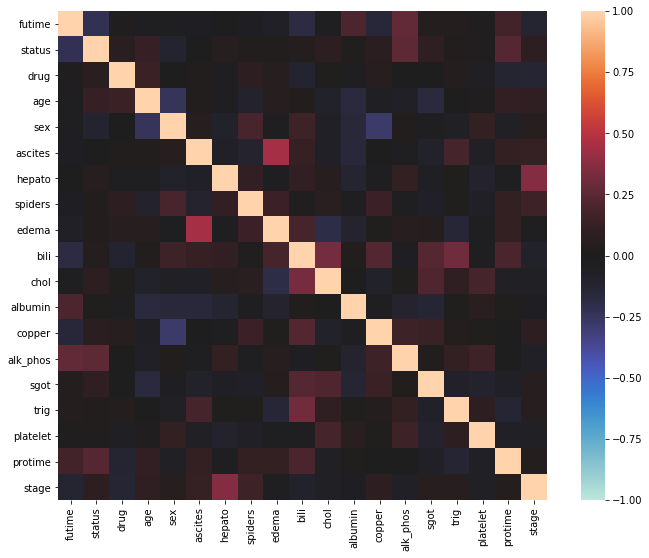

In [33]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(partial_corr, square=True, vmax=1, vmin=-1, center=0)
#plt.savefig('./exports/partial_corr_seaborn_heatmap_PBC.png')

In [62]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
 
# 説明変数に、drugカラム含め、drugカラムと（偏）相関がある変数を利用場合
#x_columns_clf = ['drug', 'age', 'bili', 'spiders', 'protime', 'stage']
# status以外、全ての説明変数を含む場合
x_columns_clf = PREPROCESSED_DATA.drop('status',axis = 1).columns

X = PREPROCESSED_DATA[x_columns_clf].values

Y = PREPROCESSED_DATA['status'].values
 
# 予測モデルを作成
clf.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
# 偏回帰係数
print(pd.DataFrame({"Name":x_columns_clf,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
 
# 切片 (誤差)
print(clf.intercept_)

        Name  Coefficients
3        sex     -0.151818
4    ascites     -0.004639
0     futime     -0.000098
2        age      0.000015
12  alk_phos      0.000051
15  platelet      0.000056
9       chol      0.000187
14      trig      0.000229
11    copper      0.000396
13      sgot      0.000744
8       bili      0.005869
10   albumin      0.024892
6    spiders      0.036851
5     hepato      0.045366
17     stage      0.048003
1       drug      0.049819
7      edema      0.073834
16   protime      0.101201
-1.2644139540125607


In [68]:
#標準化あり
X = preprocess_data_for_regression(PREPROCESSED_DATA, [OUTCOME_COLUMN])

clf.fit(X=X, y=PREPROCESSED_DATA[OUTCOME_COLUMN].values.astype('int'))
# 偏回帰係数

print(X.shape)
print(len(x_columns_clf))
# 偏回帰係数
print(pd.DataFrame({"Name":x_columns_clf,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
 

# 切片 (誤差)
print(clf.intercept_)

(258, 18)
18
        Name  Coefficients
0     futime     -0.109687
3        sex     -0.049363
4    ascites     -0.001212
15  platelet      0.005239
10   albumin      0.010120
14      trig      0.014839
6    spiders      0.016733
7      edema      0.020351
5     hepato      0.022682
1       drug      0.024906
8       bili      0.027708
11    copper      0.034480
17     stage      0.041282
9       chol      0.042181
13      sgot      0.042941
2        age      0.056485
16   protime      0.103912
12  alk_phos      0.109574
0.4302325581395349
